In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ape import accounts, chain, Contract, networks, project

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [4]:
# mrgl v1 constants
MAINTENANCE_UNIT = int(1e6)
SECONDS_AGO = 43200  # 12 hr TWAP

In [5]:
FILEPATH = "results/MarginalV1LPRunner_0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801_250000_0.25_0.5_1.1_0.001_50400_0.005_17998181_19311400_2400.csv"

In [6]:
[
    _,
    pool_addr,
    maintenance,
    utilization,
    skew,
    leverage,
    rel_margin_above_safe_min,
    blocks_held,
    sqrt_price_tol,
    start,
    stop,
    step
] = re.split("_", FILEPATH[len("results/"):-len(".csv")])

In [7]:
maintenance = int(maintenance)
utilization = float(utilization)
skew = float(skew)
leverage = float(leverage)
rel_margin_above_safe_min = float(rel_margin_above_safe_min)
blocks_held = int(blocks_held)
sqrt_price_tol = float(sqrt_price_tol)
start = int(start)
stop = int(stop)
step = int(step)

In [8]:
leverage

1.1

In [9]:
# values array from backtester for marginal LP pool
# values = [liquidity, sqrtPriceX96, liquidityLocked, lpTotalLiquidity, lpAmount0, lpAmount1]
df = pd.read_csv(FILEPATH)
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,_net_liquidity_liquidated_cumulative0,_net_liquidity_liquidated_cumulative1,_net_liquidity_settled_cumulative0,_net_liquidity_settled_cumulative1,_balances_pool0,_balances_pool1,_last_mrglv1_block_timestamp,_last_mrglv1_tick_cumulative,_net_liquidity_swap_fees_cumulative,_net_liquidity_position_fees_cumulative
0,17998182,1709004644,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0,0,0,0,-1,-1,0,0
1,18000582,1709004648,7670584300994031185919,4167202132338395807699794025,2556719354332184135587,10227303655326115316579,194444725826682766430738,537930456141451418304,4174832966775960060884034990,1348756457373625844877604,...,0,0,0,0,189774218310237895944109,561641194177416676999,1709004647,-237427,137636985393317458,343654829681530825
2,18002982,1709033587,7719132065630053139507,4174710322348453547773192071,2567959549941981583741,10287091615571934133701,195229681435518485902159,542050026046488183631,4198939390493444764294405442,1714990638571862423866014,...,59449971216546813775,0,0,0,188950635852505879657592,574135218550384076467,1709033586,-1704888282,178631334727951459,623425426995657421
3,18005382,1709062524,7719261591231278997722,4198900653024872100232408423,2567959549941981583741,10287221141173159990650,194107385657217905432290,545197795792706489333,4204231089501474711675342148,1665958413176292228814096,...,59449971216546813775,0,0,0,188109108083249679787657,576498926307715830204,1709062523,-3408380025,308156935953809674,623425426995657421
4,18007782,1709091496,7719402802975010730657,4198977465304902032080212171,2567959549941981583741,10287362352916891722204,194106499278590624644084,545215253345638409961,4208681782476437507208844991,1665958413176292228814096,...,59449971216546813775,0,0,0,188109108083249679787657,576513894205179341423,1709091495,-5110600543,449368679685542609,623425426995657421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724758611,12156060316623623478940,4889287321925087912301492458,4030690718737298166598,16186751035360763367765,262297234170839003301603,998908394550970485428,4875301928444821867630628907,323976533130863515655856,...,1516968080334410076794,537163035819345643343,5892383630451042553,9926473192438092763,256670719800948092117491,1061532989630399091613,1724758609,-932633501212,3869419267854893312437,19553682621521331842
544,19303782,1724787585,12167653419744880505507,4893950182312101500061595499,4030690718737298166598,16198344138482020280972,262235003229910426072282,1000577152542262652748,4693924590733693082295585449,326421624029424835360987,...,1516968080334410076794,537163035819345643343,5892383630451042553,9926473192438092763,256670719800948092117491,1062964527074246170991,1724787582,-934247497007,3881012370976150339004,19553682621521331842
545,19306182,1724816606,12179503903875679475502,4705407415138496374064821736,4030690718737298166598,16210194622612819135090,272942132453034526851434,962733042866515929541,4685171427703644151759713962,327016644406246453261884,...,1516968080334410076794,537163035819345643343,5892383630451042553,9926473192438092763,264763207469566769828016,1034712430612170085165,1724816605,-935863728215,3892862855106949308999,19553682621521331842
546,19308582,1724845567,12191158239653899384859,4686067463299251527886931064,4030690718737298166598,16221848958391038930489,274265638645411983359457,959465374257354049340,4699914448871631640965677056,328647811298964781266544,...,1516968080334410076794,537163035819345643343,5892383630451042553,9926473192438092763,265806616519522269736259,1032428671788436248787,1724845566,-937499268289,3904517190885169218356,19553682621521331842


In [10]:
df.columns

Index(['number', 'timestamp', 'values0', 'values1', 'values2', 'values3',
       'values4', 'values5', 'univ3_sqrtPriceX96', 'univ3_liquidity',
       'univ3_feeGrowthGlobal0X128', 'univ3_feeGrowthGlobal1X128',
       'univ3_observation0_tick_cumulatives',
       'univ3_observation1_tick_cumulatives', '_token_ids0', '_token_ids1',
       '_blocks_settle0', '_blocks_settle1', '_sizes_outstanding0',
       '_sizes_outstanding1', '_margins_outstanding0', '_margins_outstanding1',
       '_debts_outstanding0', '_debts_outstanding1',
       '_debts_without_funding_outstanding0',
       '_debts_without_funding_outstanding1', '_funding_rates_outstanding0',
       '_funding_rates_outstanding1', '_amounts0_locked0', '_amounts0_locked1',
       '_amounts1_locked0', '_amounts1_locked1',
       '_positions_liquidated_cumulative0',
       '_positions_liquidated_cumulative1', '_positions_settled_cumulative0',
       '_positions_settled_cumulative1', '_sizes_liquidated_cumulative0',
       '_sizes_liq

In [11]:
# plot mrgl pool tick vs oracle time weighted average tick over time
def calc_tick_from_sqrt_price_x96(sqrt_price_x96: int) -> int:
    price = (int(sqrt_price_x96) ** 2) / (1 << 192)
    return int(np.log(price) / np.log(1.0001))

In [12]:
df['tick'] = df['values1'].apply(calc_tick_from_sqrt_price_x96)
df['tick']

0     -58900
1     -58904
2     -58868
3     -58753
4     -58752
       ...  
543   -55708
544   -55689
545   -56475
546   -56557
547   -56538
Name: tick, Length: 548, dtype: int64

In [13]:
def calc_time_weighted_average_tick(tick_cumulatives_diff: int) -> int:
    return int(tick_cumulatives_diff) // int(SECONDS_AGO)

In [14]:
# observation0 at timestamp - seconds_ago; observation1 at timestamp
df['oracle_tick'] = (df['univ3_observation1_tick_cumulatives'] - df['univ3_observation0_tick_cumulatives']).apply(calc_time_weighted_average_tick)
df['oracle_tick']

0     -58932
1     -58893
2     -58825
3     -58756
4     -58732
       ...  
543   -55796
544   -56295
545   -56600
546   -56609
547   -56511
Name: oracle_tick, Length: 548, dtype: int64

<Axes: xlabel='number'>

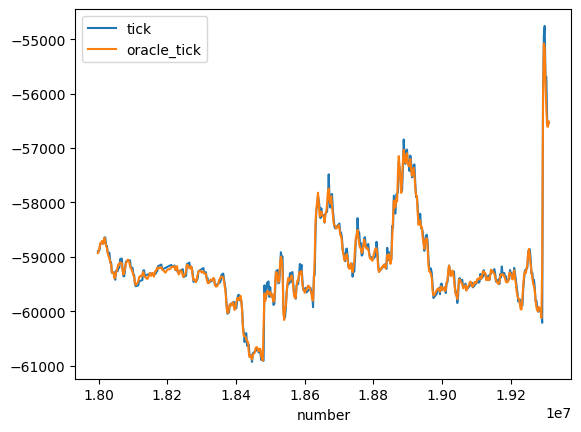

In [15]:
df.plot(x='number', y=['tick', 'oracle_tick'])

<Axes: xlabel='number'>

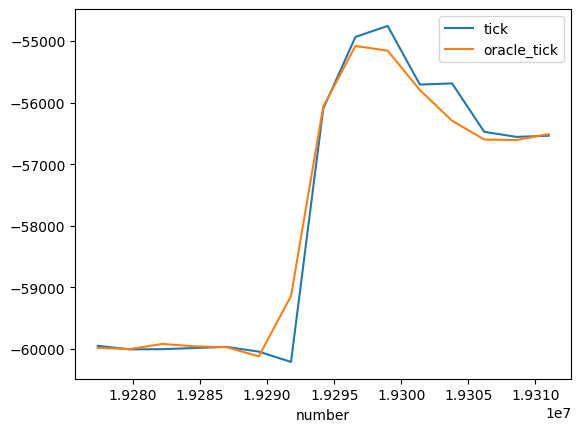

In [16]:
# zoom in to a 5 day window at end to see oracle tick timelag
# 12 hr TWAP lags so insurance mechanism for LPs must be robust to guarantee no bad debt
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['tick', 'oracle_tick'])

In [17]:
# plot mrgl pool price vs oracle time weighted average price over time
def calc_price_from_tick(tick: int) -> float:
    return 1.0001 ** tick

In [18]:
df['price'] = df['tick'].apply(calc_price_from_tick)
df['price']

0      0.002768
1      0.002767
2      0.002777
3      0.002809
4      0.002809
         ...   
543    0.003808
544    0.003816
545    0.003527
546    0.003499
547    0.003505
Name: price, Length: 548, dtype: float64

In [19]:
df['oracle_price'] = df['oracle_tick'].apply(calc_price_from_tick)
df['oracle_price']

0      0.002759
1      0.002770
2      0.002789
3      0.002808
4      0.002815
         ...   
543    0.003775
544    0.003591
545    0.003484
546    0.003480
547    0.003515
Name: oracle_price, Length: 548, dtype: float64

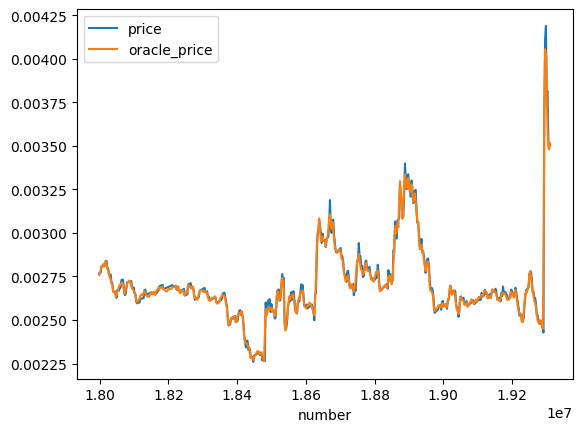

In [20]:
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-prices.png"
ax = df.plot(x='number', y=['price', 'oracle_price'])
ax.get_figure().savefig(fp)

<Axes: xlabel='number'>

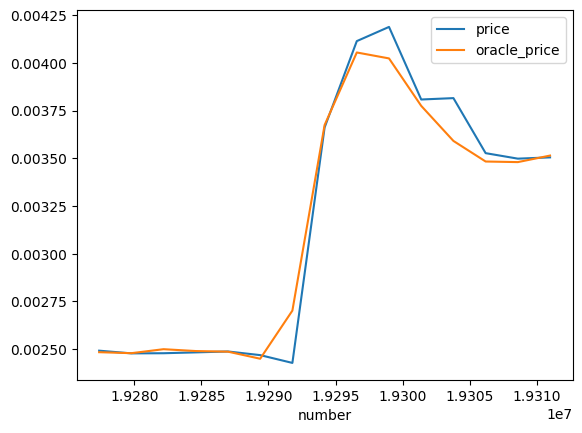

In [21]:
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['price', 'oracle_price'])

In [22]:
# plot liquidity gained over time. convert to datatype first
df['lp_total_liquidity'] = df['values3'].apply(lambda v: int(v))
df['lp_amount0'] = df['values4'].apply(lambda v: int(v))
df['lp_amount1'] = df['values5'].apply(lambda v: int(v))

In [23]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,_last_mrglv1_tick_cumulative,_net_liquidity_swap_fees_cumulative,_net_liquidity_position_fees_cumulative,tick,oracle_tick,price,oracle_price,lp_total_liquidity,lp_amount0,lp_amount1
0,17998182,1709004644,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,-1,0,0,-58900,-58932,0.002768,0.002759,10226805916623746957673,194397552620084053872985,538008621233460338723
1,18000582,1709004648,7670584300994031185919,4167202132338395807699794025,2556719354332184135587,10227303655326115316579,194444725826682766430738,537930456141451418304,4174832966775960060884034990,1348756457373625844877604,...,-237427,137636985393317458,343654829681530825,-58904,-58893,0.002767,0.002770,10227303655326115316579,194444725826682766430738,537930456141451418304
2,18002982,1709033587,7719132065630053139507,4174710322348453547773192071,2567959549941981583741,10287091615571934133701,195229681435518485902159,542050026046488183631,4198939390493444764294405442,1714990638571862423866014,...,-1704888282,178631334727951459,623425426995657421,-58868,-58825,0.002777,0.002789,10287091615571934133701,195229681435518485902159,542050026046488183631
3,18005382,1709062524,7719261591231278997722,4198900653024872100232408423,2567959549941981583741,10287221141173159990650,194107385657217905432290,545197795792706489333,4204231089501474711675342148,1665958413176292228814096,...,-3408380025,308156935953809674,623425426995657421,-58753,-58756,0.002809,0.002808,10287221141173159990650,194107385657217905432290,545197795792706489333
4,18007782,1709091496,7719402802975010730657,4198977465304902032080212171,2567959549941981583741,10287362352916891722204,194106499278590624644084,545215253345638409961,4208681782476437507208844991,1665958413176292228814096,...,-5110600543,449368679685542609,623425426995657421,-58752,-58732,0.002809,0.002815,10287362352916891722204,194106499278590624644084,545215253345638409961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724758611,12156060316623623478940,4889287321925087912301492458,4030690718737298166598,16186751035360763367765,262297234170839003301603,998908394550970485428,4875301928444821867630628907,323976533130863515655856,...,-932633501212,3869419267854893312437,19553682621521331842,-55708,-55796,0.003808,0.003775,16186751035360763367765,262297234170839003301603,998908394550970485428
544,19303782,1724787585,12167653419744880505507,4893950182312101500061595499,4030690718737298166598,16198344138482020280972,262235003229910426072282,1000577152542262652748,4693924590733693082295585449,326421624029424835360987,...,-934247497007,3881012370976150339004,19553682621521331842,-55689,-56295,0.003816,0.003591,16198344138482020280972,262235003229910426072282,1000577152542262652748
545,19306182,1724816606,12179503903875679475502,4705407415138496374064821736,4030690718737298166598,16210194622612819135090,272942132453034526851434,962733042866515929541,4685171427703644151759713962,327016644406246453261884,...,-935863728215,3892862855106949308999,19553682621521331842,-56475,-56600,0.003527,0.003484,16210194622612819135090,272942132453034526851434,962733042866515929541
546,19308582,1724845567,12191158239653899384859,4686067463299251527886931064,4030690718737298166598,16221848958391038930489,274265638645411983359457,959465374257354049340,4699914448871631640965677056,328647811298964781266544,...,-937499268289,3904517190885169218356,19553682621521331842,-56557,-56609,0.003499,0.003480,16221848958391038930489,274265638645411983359457,959465374257354049340


In [24]:
df['net_liquidity_settled_cumulative_zero_for_one'] = df['_net_liquidity_settled_cumulative0'].apply(lambda v: int(v))
df['net_liquidity_settled_cumulative_one_for_zero'] = df['_net_liquidity_settled_cumulative1'].apply(lambda v: int(v))
df['net_liquidity_settled_cumulative'] = df['net_liquidity_settled_cumulative_zero_for_one'] + df['net_liquidity_settled_cumulative_one_for_zero']

df['net_liquidity_liquidated_cumulative_zero_for_one'] = df['_net_liquidity_liquidated_cumulative0'].apply(lambda v: int(v))
df['net_liquidity_liquidated_cumulative_one_for_zero'] = df['_net_liquidity_liquidated_cumulative1'].apply(lambda v: int(v))
df['net_liquidity_liquidated_cumulative'] = df['net_liquidity_liquidated_cumulative_zero_for_one'] + df['net_liquidity_liquidated_cumulative_one_for_zero']

df['net_liquidity_swap_fees_cumulative'] = df['_net_liquidity_swap_fees_cumulative'].apply(lambda v: int(v))
df['net_liquidity_position_fees_cumulative'] = df['_net_liquidity_position_fees_cumulative'].apply(lambda v: int(v))
df['net_liquidity_fees_cumulative'] = df['net_liquidity_swap_fees_cumulative'] + df['net_liquidity_position_fees_cumulative']

In [25]:
df['net_liquidity_total_cumulative'] = df['lp_total_liquidity'] - df['lp_total_liquidity'].iloc[0]

In [26]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,net_liquidity_settled_cumulative_zero_for_one,net_liquidity_settled_cumulative_one_for_zero,net_liquidity_settled_cumulative,net_liquidity_liquidated_cumulative_zero_for_one,net_liquidity_liquidated_cumulative_one_for_zero,net_liquidity_liquidated_cumulative,net_liquidity_swap_fees_cumulative,net_liquidity_position_fees_cumulative,net_liquidity_fees_cumulative,net_liquidity_total_cumulative
0,17998182,1709004644,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0.000000e+00,0,0,0,0,0,0,0
1,18000582,1709004648,7670584300994031185919,4167202132338395807699794025,2556719354332184135587,10227303655326115316579,194444725826682766430738,537930456141451418304,4174832966775960060884034990,1348756457373625844877604,...,0,0,0.000000e+00,0,0,0,137636985393317458,343654829681530825,481291815074848283,497738702368358906
2,18002982,1709033587,7719132065630053139507,4174710322348453547773192071,2567959549941981583741,10287091615571934133701,195229681435518485902159,542050026046488183631,4198939390493444764294405442,1714990638571862423866014,...,0,0,0.000000e+00,59449971216546813775,0,59449971216546813775,178631334727951459,623425426995657421,802056761723608880,60285698948187176028
3,18005382,1709062524,7719261591231278997722,4198900653024872100232408423,2567959549941981583741,10287221141173159990650,194107385657217905432290,545197795792706489333,4204231089501474711675342148,1665958413176292228814096,...,0,0,0.000000e+00,59449971216546813775,0,59449971216546813775,308156935953809674,623425426995657421,931582362949467095,60415224549413032977
4,18007782,1709091496,7719402802975010730657,4198977465304902032080212171,2567959549941981583741,10287362352916891722204,194106499278590624644084,545215253345638409961,4208681782476437507208844991,1665958413176292228814096,...,0,0,0.000000e+00,59449971216546813775,0,59449971216546813775,449368679685542609,623425426995657421,1072794106681200030,60556436293144764531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724758611,12156060316623623478940,4889287321925087912301492458,4030690718737298166598,16186751035360763367765,262297234170839003301603,998908394550970485428,4875301928444821867630628907,323976533130863515655856,...,5892383630451042553,9926473192438092763,1.581886e+19,1516968080334410076794,537163035819345643343,2054131116153755720137,3869419267854893312437,19553682621521331842,3888972950476414644279,5959945118737016410092
544,19303782,1724787585,12167653419744880505507,4893950182312101500061595499,4030690718737298166598,16198344138482020280972,262235003229910426072282,1000577152542262652748,4693924590733693082295585449,326421624029424835360987,...,5892383630451042553,9926473192438092763,1.581886e+19,1516968080334410076794,537163035819345643343,2054131116153755720137,3881012370976150339004,19553682621521331842,3900566053597671670846,5971538221858273323299
545,19306182,1724816606,12179503903875679475502,4705407415138496374064821736,4030690718737298166598,16210194622612819135090,272942132453034526851434,962733042866515929541,4685171427703644151759713962,327016644406246453261884,...,5892383630451042553,9926473192438092763,1.581886e+19,1516968080334410076794,537163035819345643343,2054131116153755720137,3892862855106949308999,19553682621521331842,3912416537728470640841,5983388705989072177417
546,19308582,1724845567,12191158239653899384859,4686067463299251527886931064,4030690718737298166598,16221848958391038930489,274265638645411983359457,959465374257354049340,4699914448871631640965677056,328647811298964781266544,...,5892383630451042553,9926473192438092763,1.581886e+19,1516968080334410076794,537163035819345643343,2054131116153755720137,3904517190885169218356,19553682621521331842,3924070873506690550198,599504304176

In [27]:
# put in yield terms relative to initial liquidity
df['lp_total_liquidity'].iloc[0]

10226805916623746957673

In [28]:
df['yield_liquidity_total'] = (df['lp_total_liquidity'] / df['lp_total_liquidity'].iloc[0] - 1)
df['yield_liquidity_fees'] = (df['net_liquidity_fees_cumulative'] / df['lp_total_liquidity'].iloc[0])
df['yield_liquidity_settled'] = (df['net_liquidity_settled_cumulative'] / df['lp_total_liquidity'].iloc[0])
df['yield_liquidity_liquidated'] = (df['net_liquidity_liquidated_cumulative'] / df['lp_total_liquidity'].iloc[0])

In [29]:
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,net_liquidity_liquidated_cumulative_one_for_zero,net_liquidity_liquidated_cumulative,net_liquidity_swap_fees_cumulative,net_liquidity_position_fees_cumulative,net_liquidity_fees_cumulative,net_liquidity_total_cumulative,yield_liquidity_total,yield_liquidity_fees,yield_liquidity_settled,yield_liquidity_liquidated
0,17998182,1709004644,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,18000582,1709004648,7670584300994031185919,4167202132338395807699794025,2556719354332184135587,10227303655326115316579,194444725826682766430738,537930456141451418304,4174832966775960060884034990,1348756457373625844877604,...,0,0,137636985393317458,343654829681530825,481291815074848283,497738702368358906,0.000049,0.000047,0.0,0.0
2,18002982,1709033587,7719132065630053139507,4174710322348453547773192071,2567959549941981583741,10287091615571934133701,195229681435518485902159,542050026046488183631,4198939390493444764294405442,1714990638571862423866014,...,0,59449971216546813775,178631334727951459,623425426995657421,802056761723608880,60285698948187176028,0.005895,0.000078,0.0,0.005813
3,18005382,1709062524,7719261591231278997722,4198900653024872100232408423,2567959549941981583741,10287221141173159990650,194107385657217905432290,545197795792706489333,4204231089501474711675342148,1665958413176292228814096,...,0,59449971216546813775,308156935953809674,623425426995657421,931582362949467095,60415224549413032977,0.005908,0.000091,0.0,0.005813
4,18007782,1709091496,7719402802975010730657,4198977465304902032080212171,2567959549941981583741,10287362352916891722204,194106499278590624644084,545215253345638409961,4208681782476437507208844991,1665958413176292228814096,...,0,59449971216546813775,449368679685542609,623425426995657421,1072794106681200030,60556436293144764531,0.005921,0.000105,0.0,0.005813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724758611,12156060316623623478940,4889287321925087912301492458,4030690718737298166598,16186751035360763367765,262297234170839003301603,998908394550970485428,4875301928444821867630628907,323976533130863515655856,...,537163035819345643343,2054131116153755720137,3869419267854893312437,19553682621521331842,3888972950476414644279,5959945118737016410092,0.582777,0.380272,0.001547,0.200858
544,19303782,1724787585,12167653419744880505507,4893950182312101500061595499,4030690718737298166598,16198344138482020280972,262235003229910426072282,1000577152542262652748,4693924590733693082295585449,326421624029424835360987,...,537163035819345643343,2054131116153755720137,3881012370976150339004,19553682621521331842,3900566053597671670846,5971538221858273323299,0.58391,0.381406,0.001547,0.200858
545,19306182,1724816606,12179503903875679475502,4705407415138496374064821736,4030690718737298166598,16210194622612819135090,272942132453034526851434,962733042866515929541,4685171427703644151759713962,327016644406246453261884,...,537163035819345643343,2054131116153755720137,3892862855106949308999,19553682621521331842,3912416537728470640841,5983388705989072177417,0.585069,0.382565,0.001547,0.200858
546,19308582,1724845567,12191158239653899384859,4686067463299251527886931064,4030690718737298166598,16221848958391038930489,274265638645411983359457,959465374257354049340,4699914448871631640965677056,328647811298964781266544,...,537163035819345643343,2054131116153755720137,3904517190885169218356,19553682621521331842,3924070873506690550198,5995043041767291972816,0.586209,0.383704,0.001547,0.200858


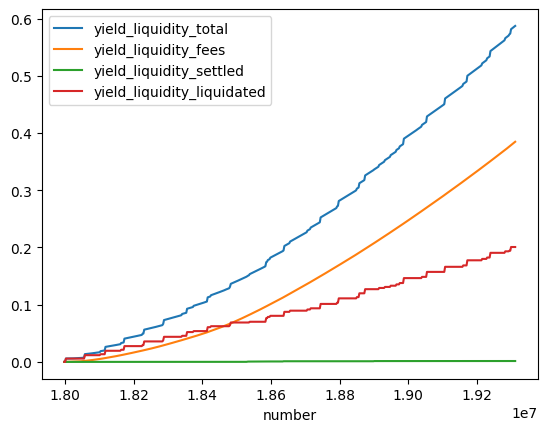

In [30]:
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields.png"
ax = df.plot(x='number', y=['yield_liquidity_total', 'yield_liquidity_fees', 'yield_liquidity_settled', 'yield_liquidity_liquidated'])
ax.get_figure().savefig(fp)

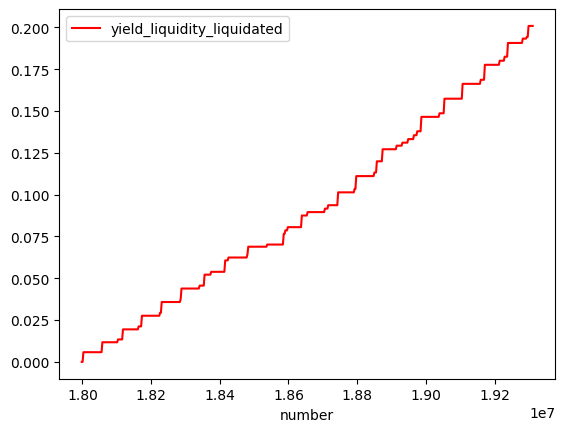

In [31]:
# look at net liquidity liquidated over time and check no shortfalls due to liquidations (i.e. no bad debt)
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields-liquidated.png"
ax = df.plot(x='number', y=['yield_liquidity_liquidated'], color=['r'])
ax.get_figure().savefig(fp)

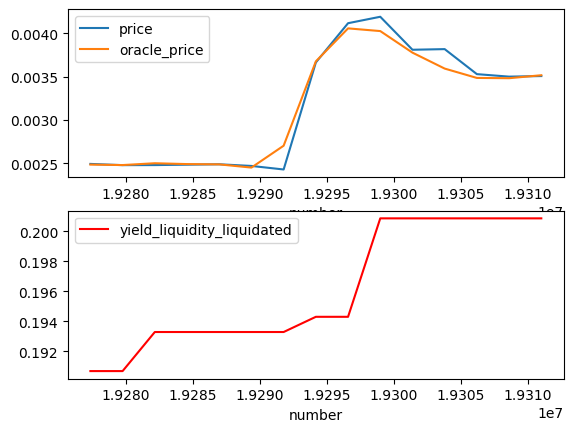

In [32]:
# focus on last 5 day window ...
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-price_vs_liquidations_yield_T-5.png"
fig, ax = plt.subplots(2, 1)
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['price', 'oracle_price'], ax=ax[0])
df[df['timestamp'] > df['timestamp'].iloc[-1] - 5 * 86400].plot(x='number', y=['yield_liquidity_liquidated'], color=['r'], ax=ax[1])
fig.savefig(fp)

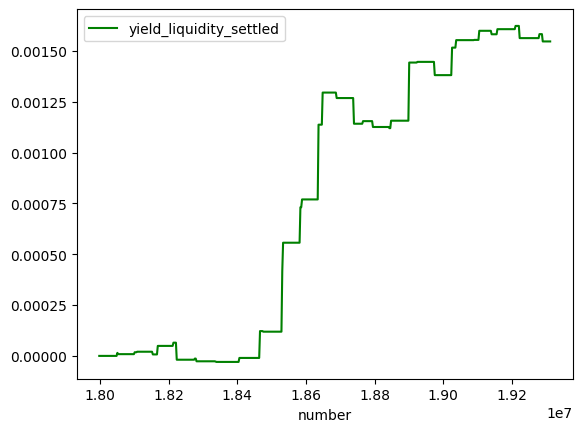

In [33]:
# and for settled? dependent on funding rates. order of mag smaller than contribution from liquidations
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields-settled.png"
ax = df.plot(x='number', y=['yield_liquidity_settled'], color=['g'])
ax.get_figure().savefig(fp)

In [34]:
def calc_reserves_from_liquidity_sqrt_price_x96(sqrt_price_x96: int, liquidity: int) -> (int, int):
    amount0 = (int(liquidity) << 96) // int(sqrt_price_x96)
    amount1 = (int(liquidity) * int(sqrt_price_x96)) // (1 << 96)
    return (amount0, amount1)

In [35]:
# check actual token balances in the pool can cover pool liquidity post-settle, liquidate of outstanding positions
df['balance0_pool'] = df['_balances_pool0'].apply(lambda v: int(v))
df['balance1_pool'] = df['_balances_pool1'].apply(lambda v: int(v))

In [36]:
df["liquidity"] = df["values0"].apply(lambda v: int(v))
df["sqrtPriceX96"] = df["values1"].apply(lambda v: int(v))

In [37]:
df['reserve0'] = df.apply(lambda x: calc_reserves_from_liquidity_sqrt_price_x96(x.sqrtPriceX96, x.liquidity)[0], axis=1)
df['reserve1'] = df.apply(lambda x: calc_reserves_from_liquidity_sqrt_price_x96(x.sqrtPriceX96, x.liquidity)[1], axis=1)

In [38]:
df['amounts0_locked_zero_for_one'] = df['_amounts0_locked0'].apply(lambda v: int(v))
df['amounts1_locked_zero_for_one'] = df['_amounts1_locked0'].apply(lambda v: int(v))
df['amounts0_locked_one_for_zero'] = df['_amounts0_locked1'].apply(lambda v: int(v))
df['amounts1_locked_one_for_zero'] = df['_amounts1_locked1'].apply(lambda v: int(v))

In [39]:
df['collaterals_zero_for_one'] = df['_sizes_outstanding0'].apply(lambda v: int(v)) + df['_margins_outstanding0'].apply(lambda v: int(v))
df['debts_zero_for_one'] = df['_debts_outstanding0'].apply(lambda v: int(v))
df['collaterals_one_for_zero'] = df['_sizes_outstanding1'].apply(lambda v: int(v)) + df['_margins_outstanding1'].apply(lambda v: int(v))
df['debts_one_for_zero'] = df['_debts_outstanding1'].apply(lambda v: int(v))

In [40]:
df['reserve0_liquidated'] = df['reserve0'] + df['amounts0_locked_zero_for_one'] + df['amounts0_locked_one_for_zero']
df['reserve1_liquidated'] = df['reserve1'] + df['amounts1_locked_zero_for_one'] + df['amounts1_locked_one_for_zero']

In [41]:
df.filter(['reserve0_liquidated', 'balance0_pool', 'reserve1_liquidated', 'balance1_pool'])

,reserve0_liquidated,balance0_pool,reserve1_liquidated,balance1_pool
0,194397552620085954736958,0,538008621233465599495,0
1,189774218310237895944116,189774218310237895944109,561641194177416676992,561641194177416676999
2,188950635852505879657598,188950635852505879657592,574135218550384076454,574135218550384076467
3,188109108083249679787663,188109108083249679787657,576498926307715830188,576498926307715830204
4,188109108083249679787663,188109108083249679787657,576513894205179341405,576513894205179341423
...,...,...,...,...
543,256670719800948092117641,256670719800948092117491,1061532989630399089962,1061532989630399091613
544,256670719800948092117641,256670719800948092117491,1062964527074246169337,1062964527074246170991
545,264763207469566769828166,264763207469566769828016,1034712430612170083506,1034712430612170085165
546,265806616519522269736409,265806616519522269736259,1032428671788436247125,1032428671788436248787


In [42]:
# should be some dust left over in pool or very little negative amounts (won't be stuck due to transfer helper lib)
df['net_balance0_pool'] = df['balance0_pool'] - df['reserve0_liquidated']
df['net_balance1_pool'] = df['balance1_pool'] - df['reserve1_liquidated']

In [43]:
df['rel_balance0_pool'] = df['net_balance0_pool'] / df['reserve0_liquidated']
df['rel_balance1_pool'] = df['net_balance1_pool'] / df['reserve1_liquidated']

In [44]:
# dust for balance check
df.filter(['net_balance0_pool', 'net_balance1_pool', 'rel_balance0_pool', 'rel_balance1_pool'])

,net_balance0_pool,net_balance1_pool,rel_balance0_pool,rel_balance1_pool
0,-194397552620085954736958,-538008621233465599495,-1.0,-1.0
1,-7,7,-0.0,0.0
2,-6,13,-0.0,0.0
3,-6,16,-0.0,0.0
4,-6,18,-0.0,0.0
...,...,...,...,...
543,-150,1651,-0.0,0.0
544,-150,1654,-0.0,0.0
545,-150,1659,-0.0,0.0
546,-150,1662,-0.0,0.0


In [45]:
print(f"last excess reserves (relative): {(df['rel_balance0_pool'].iloc[-1], df['rel_balance1_pool'].iloc[-1])}")

last excess reserves (relative): (-5.643200382447335e-22, 1.6105526412288236e-18)


<Axes: xlabel='number'>

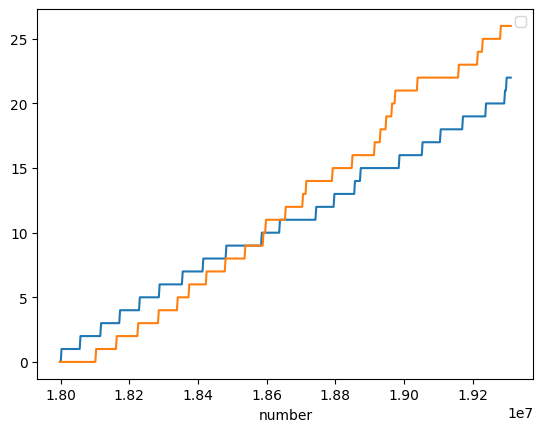

In [46]:
df.plot(x='number', y=['_positions_liquidated_cumulative0', '_positions_liquidated_cumulative1'])

In [47]:
df['sizes_outstanding_zero_for_one'] = df['_sizes_outstanding0'].apply(lambda v: int(v))
df['sizes_outstanding_one_for_zero'] = df['_sizes_outstanding1'].apply(lambda v: int(v))

In [48]:
# relative to initial total liquidity x, y amounts
df['rel_sizes_outstanding_zero_for_one'] = df['sizes_outstanding_zero_for_one'] / df['lp_amount1'].iloc[0]  # size in token1
df['rel_sizes_outstanding_one_for_zero'] = df['sizes_outstanding_one_for_zero'] / df['lp_amount0'].iloc[0]  # size in token0

<Axes: xlabel='number'>

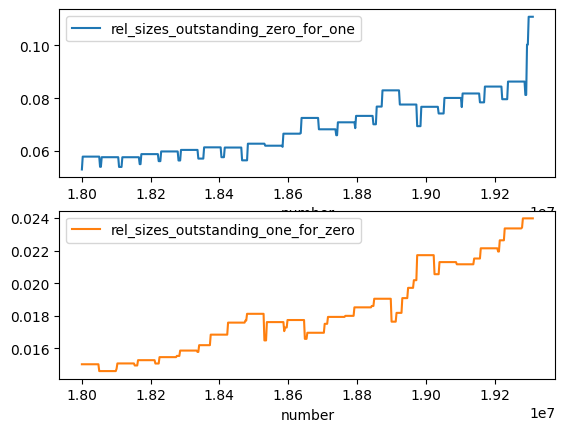

In [49]:
fig, ax = plt.subplots(2, 1)
df[1:].plot(x='number', y=['rel_sizes_outstanding_zero_for_one'], ax=ax[0], color=['C0'])
df[1:].plot(x='number', y=['rel_sizes_outstanding_one_for_zero'], ax=ax[1], color=['C1'])

In [50]:
df['sizes_liquidated_cumulative_zero_for_one'] = df['_sizes_liquidated_cumulative0'].apply(lambda v: int(v))
df['sizes_liquidated_cumulative_one_for_zero'] = df['_sizes_liquidated_cumulative1'].apply(lambda v: int(v))
df['sizes_settled_cumulative_zero_for_one'] = df['_sizes_settled_cumulative0'].apply(lambda v: int(v))
df['sizes_settled_cumulative_one_for_zero'] = df['_sizes_settled_cumulative1'].apply(lambda v: int(v))

In [51]:
# relative to initial total liquidity x, y amounts
df['rel_sizes_liquidated_cumulative_zero_for_one'] = df['sizes_liquidated_cumulative_zero_for_one'] / df['lp_amount1'].iloc[0]  # size in token1
df['rel_sizes_liquidated_cumulative_one_for_zero'] = df['sizes_liquidated_cumulative_one_for_zero'] / df['lp_amount0'].iloc[0]  # size in token0
df['rel_sizes_settled_cumulative_zero_for_one'] = df['sizes_settled_cumulative_zero_for_one'] / df['lp_amount1'].iloc[0]  # size in token1
df['rel_sizes_settled_cumulative_one_for_zero'] = df['sizes_settled_cumulative_one_for_zero'] / df['lp_amount0'].iloc[0]  # size in token0

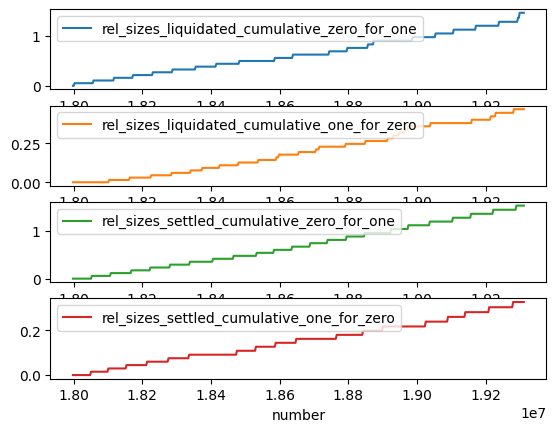

In [52]:
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-rel-sizes-liquidated-settled.png"
fig, ax = plt.subplots(4, 1)
df.plot(x='number', y=['rel_sizes_liquidated_cumulative_zero_for_one'], ax=ax[0], color='C0')
df.plot(x='number', y=['rel_sizes_liquidated_cumulative_one_for_zero'], ax=ax[1], color='C1')
df.plot(x='number', y=['rel_sizes_settled_cumulative_zero_for_one'], ax=ax[2], color='C2')
df.plot(x='number', y=['rel_sizes_settled_cumulative_one_for_zero'], ax=ax[3], color='C3')
fig.savefig(fp)

In [53]:
# examine yields in token0 or token1 terms ...
df['lp_value0_total'] = (2 * df['lp_total_liquidity'] * (1 << 96)) // df['sqrtPriceX96']
df['lp_value1_total'] = (2 * df['lp_total_liquidity'] * df['sqrtPriceX96']) // (1 << 96)

In [54]:
df['yield_value0_total'] = df['lp_value0_total'] / df['lp_value0_total'].iloc[0] - 1
df['yield_value1_total'] = df['lp_value1_total'] / df['lp_value1_total'].iloc[0] - 1

In [55]:
df.filter(['lp_value0_total', 'lp_value1_total', 'yield_value0_total', 'yield_value1_total'])

,lp_value0_total,lp_value1_total,yield_value0_total,yield_value1_total
0,388795105240168107745971,1076017242466920677447,0.0,0.0
1,388889451653365532861477,1075860912282902836609,0.000243,-0.000145
2,390459362871036971804318,1084100052092976367262,0.004281,0.007512
3,388214771314435810864580,1090395591585412978666,-0.001493,0.013363
4,388212998557181249288169,1090430506691276819922,-0.001497,0.013395
...,...,...,...,...
543,524594468341678006603207,1997816789101940970857,0.349283,0.856677
544,524470006459820852144564,2001154305084525305497,0.348962,0.859779
545,545884264906069053702868,1925466085733031859082,0.404041,0.789438
546,548531277290823966718915,1918930748514708098680,0.410849,0.783364


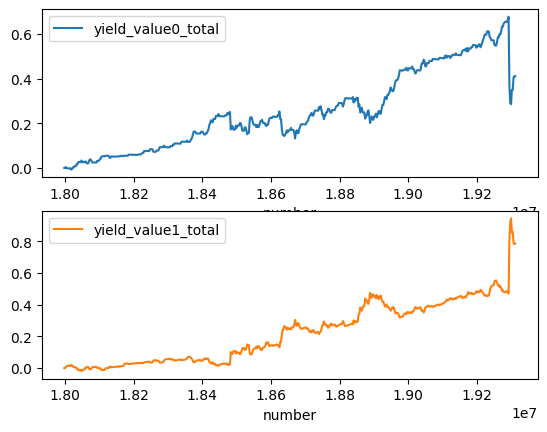

In [56]:
# yield in value terms ...
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields-value.png"
fig, ax = plt.subplots(2, 1)
df.plot(x='number', y=['yield_value0_total'], ax=ax[0], color='C0')
df.plot(x='number', y=['yield_value1_total'], ax=ax[1], color='C1')
fig.savefig(fp)

In [57]:
# benchmark against passive hold ...
df['passive_value0_total'] = df['lp_amount0'].iloc[0] + df['lp_amount1'].iloc[0] / df['price']
df['passive_value1_total'] = df['lp_amount0'].iloc[0] * df['price'] + df['lp_amount1'].iloc[0]

In [58]:
df['yield_value0_total_lp_to_passive'] = df['lp_value0_total'] / df['passive_value0_total'] - 1
df['yield_value1_total_lp_to_passive'] = df['lp_value1_total'] / df['passive_value1_total'] - 1

df['yield_value0_total_lp_to_passive'] = df['lp_value0_total'] / df['passive_value0_total'] - 1
df['yield_value1_total_lp_to_passive'] = df['lp_value1_total'] / df['passive_value1_total'] - 1

In [59]:
df.filter(['passive_value0_total', 'passive_value1_total', 'yield_value0_total_lp_to_passive', 'yield_value1_total_lp_to_passive'])

,passive_value0_total,passive_value1_total,yield_value0_total_lp_to_passive,yield_value1_total_lp_to_passive
0,388779461286455238721536.0,1076060541671180337152.0,0.00004,-0.00004
1,388857225713613870727168.0,1075845374697438183424.0,0.000083,0.000014
2,388158464353036346064896.0,1077784979224779685888.0,0.005928,0.005859
3,385943087466229983608832.0,1084027923329422852096.0,0.005886,0.005874
4,385923934828009290203136.0,1084082525259632476160.0,0.005931,0.005856
...,...,...,...,...
543,335663008219872368787456.0,1278370508095539118080.0,0.562861,0.562784
544,335394872070818651701248.0,1279778462417100996608.0,0.563739,0.563672
545,346923838782474396106752.0,1223710488680354807808.0,0.573499,0.573465
546,348179633261416686813184.0,1218111002604024627200.0,0.575426,0.575333


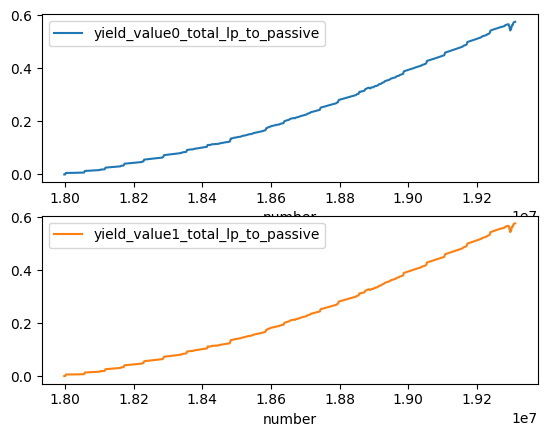

In [60]:
# similar yield increases to liquidity terms but with differences due to IL
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields-value-rel-to-passive.png"
fig, ax = plt.subplots(2, 1)
df.plot(x='number', y=['yield_value0_total_lp_to_passive'], ax=ax[0], color='C0')
df.plot(x='number', y=['yield_value1_total_lp_to_passive'], ax=ax[1], color='C1')
fig.savefig(fp)

In [61]:
# yield loss to impermanent loss
def calc_impermanent_loss(sqrt_ratio: float) -> float:
    return (2 * sqrt_ratio) / (sqrt_ratio **2 + 1) - 1

In [62]:
sqrt_ratio_end = df['sqrtPriceX96'].iloc[-1] / df['sqrtPriceX96'].iloc[0]
calc_impermanent_loss(sqrt_ratio_end)

-0.006934614852459164

In [63]:
# plot IL (approx)
df['yield_il'] = df['yield_value1_total_lp_to_passive'] - df['yield_liquidity_total']

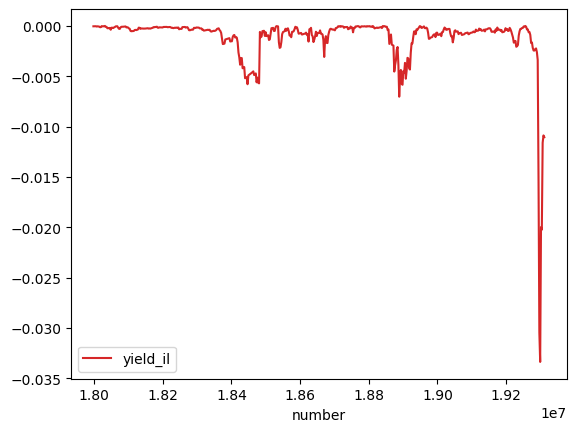

In [64]:
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-yields-il.png"
ax = df.plot(x='number', y=['yield_il'], color='C3')
ax.get_figure().savefig(fp)

In [65]:
# check out total volumes on both sides (count based at settlement/liquidation given columns)
df['rel_volumes_closed_cumulative_zero_for_one'] = df['rel_sizes_liquidated_cumulative_zero_for_one'] + df['rel_sizes_settled_cumulative_zero_for_one']
df['rel_volumes_closed_cumulative_one_for_zero'] = df['rel_sizes_liquidated_cumulative_one_for_zero'] + df['rel_sizes_settled_cumulative_one_for_zero']

In [66]:
df.filter(['rel_volumes_closed_cumulative_zero_for_one', 'rel_volumes_closed_cumulative_one_for_zero'])

,rel_volumes_closed_cumulative_zero_for_one,rel_volumes_closed_cumulative_one_for_zero
0,0.0,0.0
1,0.0,0.0
2,0.05297,0.0
3,0.05297,0.0
4,0.05297,0.0
...,...,...
543,2.990192,0.797816
544,2.990192,0.797816
545,2.990192,0.797816
546,2.990192,0.797816


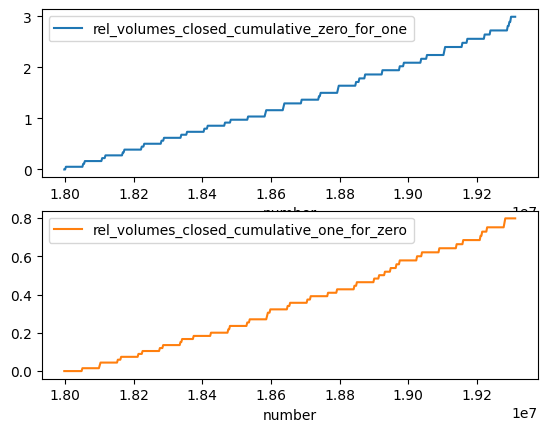

In [67]:
# cumulative volumes relative to initial TVL
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-rel_volumes_cumulative.png"
fig, ax = plt.subplots(2, 1)
df.plot(x='number', y=['rel_volumes_closed_cumulative_zero_for_one'], ax=ax[0], color='C0')
df.plot(x='number', y=['rel_volumes_closed_cumulative_one_for_zero'], ax=ax[1], color='C1')
fig.savefig(fp)

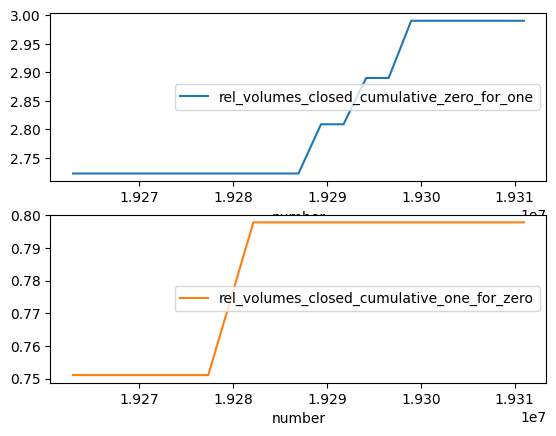

In [68]:
# zoom in over last blocks held period for sim to show turn over
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-rel_volumes_cumulative_T-blocks_held.png"
fig, ax = plt.subplots(2, 1)
df[df['timestamp'] > df['timestamp'].iloc[-1] - 12 * blocks_held].plot(x='number', y=['rel_volumes_closed_cumulative_zero_for_one'], ax=ax[0], color='C0')
df[df['timestamp'] > df['timestamp'].iloc[-1] - 12 * blocks_held].plot(x='number', y=['rel_volumes_closed_cumulative_one_for_zero'], ax=ax[1], color='C1')
fig.savefig(fp)

In [69]:
# calculate slippage amounts paid by traders on opened positions
df

,number,timestamp,values0,values1,values2,values3,values4,values5,univ3_sqrtPriceX96,univ3_liquidity,...,lp_value1_total,yield_value0_total,yield_value1_total,passive_value0_total,passive_value1_total,yield_value0_total_lp_to_passive,yield_value1_total_lp_to_passive,yield_il,rel_volumes_closed_cumulative_zero_for_one,rel_volumes_closed_cumulative_one_for_zero
0,17998182,1709004644,10226805916623846957733,4168010503442910833875654129,0,10226805916623746957673,194397552620084053872985,538008621233460338723,4168008784382137638332327128,1348756457373625844877604,...,1076017242466920677447,0.0,0.0,388779461286455238721536.0,1076060541671180337152.0,0.00004,-0.00004,-0.00004,0.0,0.0
1,18000582,1709004648,7670584300994031185919,4167202132338395807699794025,2556719354332184135587,10227303655326115316579,194444725826682766430738,537930456141451418304,4174832966775960060884034990,1348756457373625844877604,...,1075860912282902836609,0.000243,-0.000145,388857225713613870727168.0,1075845374697438183424.0,0.000083,0.000014,-0.000034,0.0,0.0
2,18002982,1709033587,7719132065630053139507,4174710322348453547773192071,2567959549941981583741,10287091615571934133701,195229681435518485902159,542050026046488183631,4198939390493444764294405442,1714990638571862423866014,...,1084100052092976367262,0.004281,0.007512,388158464353036346064896.0,1077784979224779685888.0,0.005928,0.005859,-0.000036,0.05297,0.0
3,18005382,1709062524,7719261591231278997722,4198900653024872100232408423,2567959549941981583741,10287221141173159990650,194107385657217905432290,545197795792706489333,4204231089501474711675342148,1665958413176292228814096,...,1090395591585412978666,-0.001493,0.013363,385943087466229983608832.0,1084027923329422852096.0,0.005886,0.005874,-0.000033,0.05297,0.0
4,18007782,1709091496,7719402802975010730657,4198977465304902032080212171,2567959549941981583741,10287362352916891722204,194106499278590624644084,545215253345638409961,4208681782476437507208844991,1665958413176292228814096,...,1090430506691276819922,-0.001497,0.013395,385923934828009290203136.0,1084082525259632476160.0,0.005931,0.005856,-0.000066,0.05297,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,19301382,1724758611,12156060316623623478940,4889287321925087912301492458,4030690718737298166598,16186751035360763367765,262297234170839003301603,998908394550970485428,4875301928444821867630628907,323976533130863515655856,...,1997816789101940970857,0.349283,0.856677,335663008219872368787456.0,1278370508095539118080.0,0.562861,0.562784,-0.019993,2.990192,0.797816
544,19303782,1724787585,12167653419744880505507,4893950182312101500061595499,4030690718737298166598,16198344138482020280972,262235003229910426072282,1000577152542262652748,4693924590733693082295585449,326421624029424835360987,...,2001154305084525305497,0.348962,0.859779,335394872070818651701248.0,1279778462417100996608.0,0.563739,0.563672,-0.020238,2.990192,0.797816
545,19306182,1724816606,12179503903875679475502,4705407415138496374064821736,4030690718737298166598,16210194622612819135090,272942132453034526851434,962733042866515929541,4685171427703644151759713962,327016644406246453261884,...,1925466085733031859082,0.404041,0.789438,346923838782474396106752.0,1223710488680354807808.0,0.573499,0.573465,-0.011604,2.990192,0.797816
546,19308582,1724845567,12191158239653899384859,4686067463299251527886931064,4030690718737298166598,16221848958391038930489,274265638645411983359457,959465374257354049340,4699914448871631640965677056,328647811298964781266544,...,1918930748514708098680,0.410849,0.783364,348179633261416686813184.0,1218111002604024627200.0,0.575426,0.575333,-0.010876,2.990192,0.797816


In [70]:
df['sizes_zero_for_one'] = df['_sizes_outstanding0'].apply(lambda v: int(v))
df['sizes_one_for_zero'] = df['_sizes_outstanding1'].apply(lambda v: int(v))
df['margins_zero_for_one'] = df['_margins_outstanding0'].apply(lambda v: int(v))
df['margins_one_for_zero'] = df['_margins_outstanding1'].apply(lambda v: int(v))

In [71]:
df.filter(['sizes_zero_for_one', 'debts_zero_for_one', 'margins_zero_for_one', 'sizes_one_for_zero', 'debts_one_for_zero', 'margins_one_for_zero', 'price'])

,sizes_zero_for_one,debts_zero_for_one,margins_zero_for_one,sizes_one_for_zero,debts_one_for_zero,margins_one_for_zero,price
0,0,0,0,0,0,0,0.002768
1,28498412008710801053,10873229716989707788720,9125485732798308352,2922393997470247882983,7383659548749728028,796669014456888328192,0.002767
2,31122898107204701454,10679363090491029565450,10184734189421658112,2922393997470247882983,7382552138244882169,796669014456888328192,0.002777
3,31122898107204701454,10683635476531729927036,10184734189421658112,2922393997470247882983,7379968826265909068,796669014456888328192,0.002809
4,31122898107204701454,10684169644951679853355,10184734189421658112,2922393997470247882983,7379599855497172833,796669014456888328192,0.002809
...,...,...,...,...,...,...,...
543,59662965463525570445,13714370459175196635538,19523728069039198208,4659805071966098013135,11238079952982935378,1269802222060471058432,0.003808
544,59662965463525570445,13705459460307608372431,19523728069039198208,4659805071966098013135,11245386714060513267,1269802222060471058432,0.003816
545,59662965463525570445,13650749850064268201370,19523728069039198208,4659805071966098013135,11290456086140391355,1269802222060471058432,0.003527
546,59662965463525570445,13643926522274032870209,19523728069039198208,4659805071966098013135,11296102443341980371,1269802222060471058432,0.003499


In [72]:
# pnl on open position is (size / (debt * price) - 1) for zeroForOne = true and (size * price / debt - 1) for zeroForOne = false
def pnl(x) -> (float, float):
    if x.margins_zero_for_one == 0 or x.margins_one_for_zero == 0:
            return (0, 0)
    p01 = (x.margins_zero_for_one + (x.sizes_zero_for_one - x.debts_zero_for_one * x.price)) / x.margins_zero_for_one - 1
    p10 = (x.margins_one_for_zero + (x.sizes_one_for_zero - x.debts_one_for_zero / x.price)) / x.margins_one_for_zero - 1
    return (p01, p10)

In [73]:
def effective_leverage(x) -> (float, float):
    if x.margins_zero_for_one == 0 or x.margins_one_for_zero == 0:
            return (0, 0)
    l01 = (x.margins_zero_for_one + x.debts_zero_for_one * x.price) / x.margins_zero_for_one
    l10 = (x.margins_one_for_zero + x.debts_one_for_zero / x.price) / x.margins_one_for_zero
    return (l01, l10)

In [74]:
leverage

1.1

In [75]:
# check should be = leverage - 1 if leverage was user input
df[1:]['sizes_zero_for_one'] / df[1:]['margins_zero_for_one']

1      3.122947
2      3.055838
3      3.055838
4      3.055838
5      3.055838
         ...   
543    3.055921
544    3.055921
545    3.055921
546    3.055921
547    3.055921
Length: 547, dtype: object

In [76]:
df[1:]['sizes_one_for_zero'] / df[1:]['margins_one_for_zero']

1      3.668266
2      3.668266
3      3.668266
4      3.668266
5      3.668266
         ...   
543    3.669709
544    3.669709
545    3.669709
546    3.669709
547    3.669709
Length: 547, dtype: object

In [77]:
df['pnl_zero_for_one'] = df.apply(lambda x: pnl(x)[0], axis=1)
df['pnl_one_for_zero'] = df.apply(lambda x: pnl(x)[1], axis=1)
df['effective_leverage_zero_for_one'] = df.apply(lambda x: effective_leverage(x)[0], axis=1)
df['effective_leverage_one_for_zero'] = df.apply(lambda x: effective_leverage(x)[1], axis=1)

In [78]:
df.filter(['pnl_zero_for_one', 'pnl_one_for_zero', 'effective_leverage_zero_for_one', 'effective_leverage_one_for_zero'])

,pnl_zero_for_one,pnl_one_for_zero,effective_leverage_zero_for_one,effective_leverage_one_for_zero
0,0.000000,0.000000,0.000000,0.000000
1,-0.173622,0.318349,4.296570,4.349917
2,0.144325,0.330887,3.911513,4.337379
3,0.109473,0.370200,3.946365,4.298066
4,0.109031,0.370694,3.946807,4.297572
...,...,...,...,...
543,0.380658,1.345888,3.675262,3.323822
544,0.377312,1.348791,3.678608,3.320919
545,0.589664,1.148953,3.466257,3.520756
546,0.611026,1.126928,3.444895,3.542781


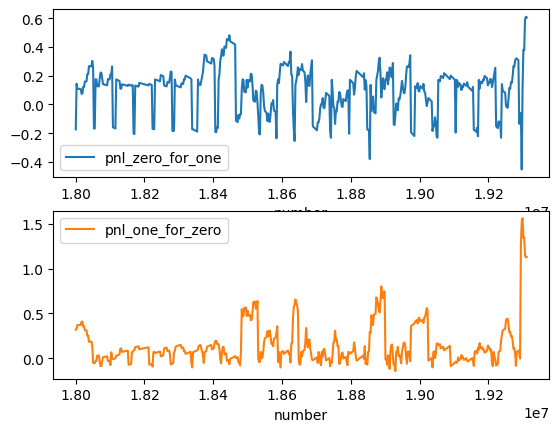

In [79]:
# pnl paid out to positions relative to initial margin
# compared with net liquidity gains from settlement show safety for pool LPs due to physical settlement
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-position_pnl.png"
fig, ax = plt.subplots(2, 1)
df[1:].plot(x='number', y=['pnl_zero_for_one'], ax=ax[0], color='C0')
df[1:].plot(x='number', y=['pnl_one_for_zero'], ax=ax[1], color='C1')
fig.savefig(fp)

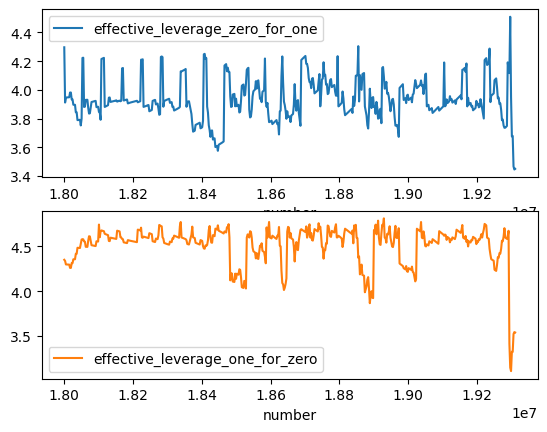

In [80]:
# effective leverage on positions relative to initial margin accounting for slippage increases to debt
fp = "assets/" + FILEPATH[len("results/"):-len(".csv")] + "-position_effective_leverage.png"
fig, ax = plt.subplots(2, 1)
df[1:].plot(x='number', y=['effective_leverage_zero_for_one'], ax=ax[0], color='C0')
df[1:].plot(x='number', y=['effective_leverage_one_for_zero'], ax=ax[1], color='C1')
fig.savefig(fp)